# Mineria de Textos - PEC 2

In [1]:
# Libraries
import numpy as np
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt

# Data Preparation

We iterate through all 7 subfolders, extracting the path of each one, and the names of each of the files. All such files have an associated label generated while iterating.

In [2]:
import os

# Specify the folder path
folder_path = './Corpus-Clustering/'

# Global Variables
counter = 0
all_paths = []
all_files = []
all_labels = []

# Iterate through the files and subfolders
for root, _, files in os.walk(folder_path):
  if counter != 0: # Skipping first folder in mac OS (.DSstore)
    all_files.extend(files)
    all_paths.append(root)
    labels = counter*np.ones(len(files))
    all_labels = np.concatenate((all_labels, labels))
  counter += 1

# Pre-processing

In [3]:
# Choosing one document to see how it changes at eavh stage
sample_id = 410

## Remove Headers
- Split text into chunks where there are AT LEAST 2 consecutive new line characters.
- Then eliminate the first chunk, which corresponds to the header of the file.
- Eliminate symbols "<" and ">".
- Remove emails
- Keep only words and numbers
- Make everything lower case

In [4]:
def preprocessing(file_path):
  with open(file_path, "r") as file:
    text = file.read()
    pattern = r"\n\s*\n" # See https://regex101.com
    split_text_chunks = re.split(pattern, text)  # Regex pattern
    if split_text_chunks:
      split_text = split_text_chunks[1:-1] # Original text - header - footer (first and last entries respectively in split list generated)
      separator = "\n\n" # Introducing back at least 1 empty line
      new_text = separator.join(split_text).replace("<", "").replace(">", "") # Joining into a whole text (str)
      # Remove emails
      email_pattern = r"[\w\.-]+@[\w\.-]+\.\w{2,}"  # Matches common email formats
      clean_text = re.sub(email_pattern, "", new_text)
      # Matching non-words and replacing them with empty strings
      clean_text = re.sub(r"[^a-zA-Z0-9\s]", "", clean_text) #[\_|=\[\]/\\,.!?()+\-;:]
      # Make everything lowercase
      clean_text = clean_text.lower()
      # return new_text
      return clean_text
  return None

# Remove header from all files, and save in corpus variable:
preprocessed_corpus = []
errors_idx = []
for idx, filename in enumerate(all_files):
  file_path = f"{all_paths[int(all_labels[idx] - 1)]}/{filename}"
  try:
    text_body = preprocessing(file_path)
    preprocessed_corpus.append(text_body)
  except:
    errors_idx.append(idx)

In [5]:
# Calculating stats of a list of strings. Labels also provided
def stats_corpus(list_of_strings, labels):
  n_words_per_document = []
  for string in list_of_strings:
    n_words_per_document.append(len(string.split()))

  df_corpus_preprocessed = pd.DataFrame({'labels': labels, 'n_words': n_words_per_document})

  grouped_stats = df_corpus_preprocessed.groupby('labels').agg(['mean', 'std'])
  return round(grouped_stats, 0)


In [6]:
# All folder
pd.DataFrame({'folder_name': all_paths, 'label': [1, 2, 3, 4, 5, 6, 7], 'n_docs': pd.Series(all_labels).value_counts().sort_index()})

,folder_name,label,n_docs
1.0,./Corpus-Clustering/talk.politics.mideast,1,72
2.0,./Corpus-Clustering/rec.autos,2,61
3.0,./Corpus-Clustering/comp.sys.mac.hardware,3,146
4.0,./Corpus-Clustering/rec.sport.hockey,4,50
5.0,./Corpus-Clustering/comp.sys.ibm.pc.hardware,5,124
6.0,./Corpus-Clustering/sci.electronics,6,211
7.0,./Corpus-Clustering/talk.politics.guns,7,141


In [7]:
# Creating X and y:
X_preprocessed = preprocessed_corpus
y = all_labels
stats_corpus(X_preprocessed, y)

n_words        
          mean     std
labels                
1.0      630.0  1291.0
2.0      150.0   165.0
3.0      119.0   107.0
4.0      209.0   262.0
5.0      179.0   367.0
6.0      202.0   797.0
7.0      325.0   382.0

Inspecting one entry (document) of the corpus before preprocessing:

In [8]:
file_path = f"{all_paths[int(all_labels[sample_id] - 1)]}/{int(all_files[sample_id])}"
with open(file_path, "r") as file:
    text = file.read()
    print(text)

Newsgroups: comp.sys.ibm.pc.hardware
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!wupost!uunet!mcsun!sun4nl!kubds1.kub.nl!volkert
From: volkert@kub.nl (Volkert)
Subject: RE: 80486DX-50 vs 80586DX2-50
Message-ID: <1993Apr06.121342.25130@kub.nl>
Date: Tue, 06 Apr 93 12:13:42 GMT
Organization: Tilburg University, Tilburg, The Netherlands
Nntp-Posting-Host: itkdsh.kub.nl
Lines: 19

-------------------------------------------------------------------------
Anonymous,

I saw a posting about the choice between 80486DX-50 and a 80486DX2-50.
I was wondering: although a DX-50 is faster because of the path to it's
external cache, shouldn't the choice be the DX2-50 as that one can be
made to work properly with a local-bus? I mean, cache speed is one thing,
but all your speed will be blocked during video I/O, so just get that
faster... 
I'm willing to speculate that the DX2-50 with local-bus will be 2-4 times 
as fast as the DX

and after preprocessing:

In [9]:
sample_doc = preprocessed_corpus[sample_id]
print(sample_doc)


anonymous

i saw a posting about the choice between 80486dx50 and a 80486dx250
i was wondering although a dx50 is faster because of the path to its
external cache shouldnt the choice be the dx250 as that one can be
made to work properly with a localbus i mean cache speed is one thing
but all your speed will be blocked during video io so just get that
faster 
im willing to speculate that the dx250 with localbus will be 24 times 
as fast as the dx50 and probably as expensive or cheap 


## Tokenization, Lemmatization, and Stop-Word removal

In [10]:
# Using Spacy's Large English Model
nlp = spacy.load("en_core_web_lg")
def spacy_tokenizer(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]  # Lemmatize and remove stop words
    return ' '.join(tokens)


In [11]:
print(spacy_tokenizer(sample_doc))


 anonymous 

 see posting choice 80486dx50 80486dx250 
 wonder dx50 fast path 
 external cache not choice dx250 
 work properly localbus mean cache speed thing 
 speed block video io 
 fast 
 m willing speculate dx250 localbus 24 time 
 fast dx50 probably expensive cheap


In [12]:
X = [spacy_tokenizer(document) for document in X_preprocessed]

One last cleaning of the data. Since the tokens are the lemmas for the words in the documents, and knowing the three following words/lemmas appear too often accross all documents, but do not provide any value to identify each group: "not", "article", "write".

In [13]:
def cleaning_lemmas(corpus):
  clean_corpus = []
  for doc in corpus:
    clean_doc = re.sub((r"(not|write|article)"), "", doc)
    clean_corpus.append(clean_doc)
  return clean_corpus

X = cleaning_lemmas(X)

In [14]:
stats_corpus(X, y)

n_words       
          mean    std
labels               
1.0      299.0  531.0
2.0       71.0   74.0
3.0       55.0   48.0
4.0      122.0  221.0
5.0       94.0  243.0
6.0       98.0  398.0
7.0      150.0  189.0

# Vectorization

## TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.5,
)

X_tfidf = vectorizer.fit_transform(X)

print(f"# Documents: {X_tfidf.shape[0]}, # Features: {X_tfidf.shape[1]}")
print(f"Non-zero entries: {(X_tfidf.nnz / np.prod(X_tfidf.shape))*100:.1f}%")

# Documents: 805, # Features: 2467
Non-zero entries: 2.1%


## Word2Vec

In [16]:
from gensim.models import Word2Vec

n_dim = 2000
w2v_model = Word2Vec(sentences=X, vector_size=n_dim, window=5, min_count=2, sg=1, workers=12)

In [17]:
def vectorize(sentence, n_dim):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(n_dim)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0) # Collapse vectorized words from given document into its average

X_w2v = np.array([vectorize(sentence, n_dim) for sentence in X])

# Clustering

## K-Means

In [18]:
from sklearn.cluster import KMeans
k = 7
kmeans = KMeans(n_clusters=k, random_state=96)
y_tfidf_kMeans_pred = kmeans.fit_predict(X_tfidf) + 1

/Users/gregoryturri/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [19]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=96)
y_w2v_kMeans_pred = kmeans.fit_predict(X_w2v) + 1

/Users/gregoryturri/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## DBSCAN

Tweak hyperparameters until obtaining known number of clusters = 7 + 1 (noisy group)

In [20]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=3, n_jobs=-1)
dbscan.fit_predict(X_tfidf)

# labels = grid_search_dbscan.best_estimator_.labels_
y_tfidf_dbscan_pred = dbscan.labels_ + 1

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(y_tfidf_dbscan_pred)) - (1 if -1 in y_tfidf_dbscan_pred else 0)
n_noise_ = list(y_tfidf_dbscan_pred).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 8
Estimated number of noise points: 0


In [21]:
np.unique(y_tfidf_dbscan_pred)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [22]:
dbscan = DBSCAN(eps=0.39, min_samples=3, n_jobs=-1)
dbscan.fit_predict(X_w2v)

# labels = grid_search_dbscan.best_estimator_.labels_
y_w2v_dbscan_pred = dbscan.labels_ + 1

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(y_w2v_dbscan_pred)) - (1 if -1 in y_w2v_dbscan_pred else 0)
n_noise_ = list(y_w2v_dbscan_pred).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 0


In [23]:
np.unique(y_w2v_dbscan_pred)

array([0, 1, 2, 3, 4])

Masks for later evaluation of the predictions:

In [24]:
dbscan_clusters = y_tfidf_dbscan_pred!=0

## LDA

LDA with sklearn:

In [25]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=7, random_state=42)
lda.fit_transform(X_tfidf)

array([[0.01104376, 0.10062621, 0.01076735, ..., 0.01123325, 0.84456542,
        0.01082433],
       [0.01815687, 0.01815231, 0.018154  , ..., 0.01815351, 0.8910785 ,
        0.01815192],
       [0.1099688 , 0.010943  , 0.01091097, ..., 0.04599333, 0.80029205,
        0.01092759],
       ...,
       [0.31417578, 0.02911296, 0.0291296 , ..., 0.02911268, 0.54023446,
        0.02911289],
       [0.04959945, 0.01493647, 0.01493686, ..., 0.01494176, 0.8757145 ,
        0.01493442],
       [0.0931697 , 0.01510147, 0.04835226, ..., 0.01534013, 0.7977393 ,
        0.01515852]])

In [26]:
# Gensim
import gensim
import gensim.corpora as corpora

LDA needs a dictionary of all words in the corpus. The X_train and X_test sets are stored as a list of strings, where each entry is a unique multiline string with all tokens. Thus, each document (entry) must be split into all tokens before creating the ```gensim.corpora.Dictionary```:

In [27]:
X_tokens = [[text for text in doc.split()] for doc in X]

In [28]:
dictionary_train = corpora.Dictionary(X_tokens)

Creating a Bag-Of-Words representations of the documents:

In [29]:
bow_X = [dictionary_train.doc2bow(doc) for doc in X_tokens]

This is used to determine the words used to describe each cluster:

In [30]:
from pprint import pprint
# number of topics
num_topics = 7
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=bow_X,
                                       id2word=dictionary_train,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_X]

[(0,
  '0.007*"drive" + 0.005*"right" + 0.005*"1" + 0.005*"2" + 0.004*"time" + '
  '0.004*"like" + 0.004*"people" + 0.004*"think" + 0.003*"know" + '
  '0.003*"look"'),
 (1,
  '0.005*"use" + 0.005*"right" + 0.005*"know" + 0.004*"want" + 0.004*"like" + '
  '0.003*"s" + 0.003*"good" + 0.003*"people" + 0.003*"think" + 0.003*"ground"'),
 (2,
  '0.006*"know" + 0.006*"people" + 0.005*"like" + 0.005*"say" + 0.004*"s" + '
  '0.004*"time" + 0.004*"go" + 0.003*"gun" + 0.003*"m" + 0.003*"work"'),
 (3,
  '0.019*"1" + 0.008*"0" + 0.006*"2" + 0.004*"people" + 0.004*"drive" + '
  '0.004*"gun" + 0.004*"like" + 0.003*"know" + 0.003*"say" + 0.003*"use"'),
 (4,
  '0.006*"know" + 0.005*"use" + 0.005*"people" + 0.005*"like" + 0.004*"right" '
  '+ 0.004*"think" + 0.004*"card" + 0.003*"want" + 0.003*"get" + 0.003*"need"'),
 (5,
  '0.005*"use" + 0.004*"drive" + 0.004*"work" + 0.004*"think" + 0.004*"good" + '
  '0.004*"system" + 0.004*"m" + 0.003*"know" + 0.003*"like" + 0.003*"people"'),
 (6,
  '0.005*"people" 

# Performance Evaluation

## Precision, Recall, F1, and Rand Score:

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, rand_score

def evaluation_metrics(y_true, y_pred):
  print('Accuracy:', accuracy_score(y_true, y_pred))
  print('Precision:', precision_score(y_true, y_pred, average='weighted'))
  print('Recall:', recall_score(y_true, y_pred, average='weighted'))
  print('F1 score:', f1_score(y_true, y_pred, average='weighted'))
  print('Rand score:', rand_score(y_true, y_pred))

In [32]:
print('\nK-Means (TF-IDF)')
evaluation_metrics(y, y_tfidf_kMeans_pred)
print('\nK-Means (Word2vec)')
evaluation_metrics(y, y_w2v_kMeans_pred)
print('\nDBSCAN (TF-IDF)')
evaluation_metrics(y[dbscan_clusters], y_tfidf_dbscan_pred[dbscan_clusters])
print('\nDBSCAN (Word2vec)')
evaluation_metrics(y[dbscan_clusters], y_w2v_dbscan_pred[dbscan_clusters])


K-Means (TF-IDF)
Accuracy: 0.22608695652173913
Precision: 0.2634816099574739
Recall: 0.22608695652173913
F1 score: 0.2049362429557294
Rand score: 0.6424461543215599

K-Means (Word2vec)
Accuracy: 0.15900621118012423
Precision: 0.18355626115609677
Recall: 0.15900621118012423
F1 score: 0.14324385520045224
Rand score: 0.6920830629461389

DBSCAN (TF-IDF)
Accuracy: 0.3333333333333333
Precision: 0.6243386243386243
Recall: 0.3333333333333333
F1 score: 0.3537928302634185
Rand score: 0.5904961565338924

DBSCAN (Word2vec)
Accuracy: 0.16666666666666666
Precision: 0.03996101364522417
Recall: 0.16666666666666666
F1 score: 0.061937201472085195
Rand score: 0.46680642907058


/Users/gregoryturri/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrices

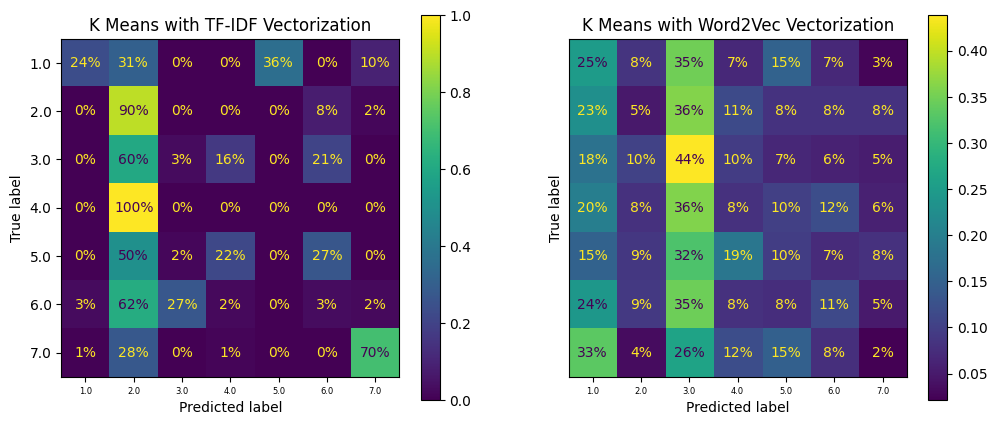

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

fuente = 10
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y, y_tfidf_kMeans_pred, ax=axs[0], normalize="true", values_format=".0%")
axs[0].set_title("K Means with TF-IDF Vectorization")
axs[0].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y, y_w2v_kMeans_pred, ax=axs[1], normalize="true", values_format=".0%")
axs[1].set_title("K Means with Word2Vec Vectorization")
axs[1].set_yticks([])
axs[1].tick_params(axis='x', labelsize=6)

plt.show()

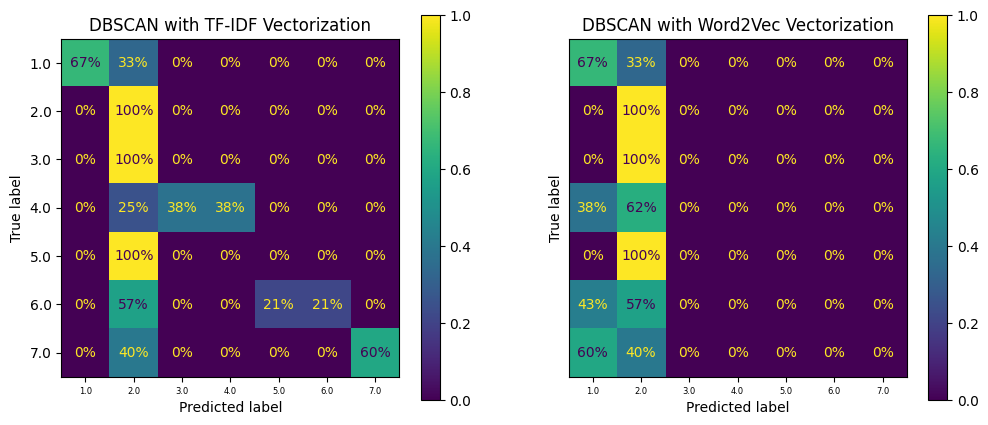

In [34]:
fuente = 10
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y[dbscan_clusters], y_tfidf_dbscan_pred[dbscan_clusters], ax=axs[0], normalize="true", values_format=".0%")
axs[0].set_title("DBSCAN with TF-IDF Vectorization")
axs[0].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y[dbscan_clusters], y_w2v_dbscan_pred[dbscan_clusters], ax=axs[1], normalize="true", values_format=".0%")
axs[1].set_title("DBSCAN with Word2Vec Vectorization")
axs[1].set_yticks([])
axs[1].tick_params(axis='x', labelsize=6)

plt.show()

## Coherence of LDA

In [35]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=X_tokens, dictionary=dictionary_train, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3746315678332004
